# FIT5196 Assessment 2
#### Student Name: Isobel Rowe
#### Student ID: 30042585

Date: 15/05/2019

Version: 2.0

Environment: Python 3.6.0 and Anaconda 4.3.0 (64-bit)

Libraries used:
* pandas (for dataframe)
* numpy (for various mathematical funtions)
* datetime (for converting datatypes)
* matplotlib.pyplot (for graphing)
* seaborn (for plotting boxplots)
* networkx (for finding paths)
* sklearn.model_selection (for train_test_split)
* sklearn.metrics (for R squared and mean squared error)
* sklearn.linear_model (for linear regression)
* sklearn.neighbors (for k-nearest neighbors)
* scipy (for stats functionality)



## 1. Introduction

This is Assignment 2 in FIT5196, which deals with the wrangling of unclean data files to find and fix the problems. It involves taking the three provided files - dirty data, missing values, and outliers - and transforming them into cleaned datasets with the use of graphical and non-graphical exploratory data analysis. The data files comprise 14 columns and varying row numbers of Uber Trip data.

Each dataset is explored in different sections:

- **Section 3: Dirty Data.** In this task, we are required to detect and fix errors in the dirty data dataset (30042585_dirty_data.csv).

- **Section 4: Outlier Data.** In this task, we are required to detect and remove outliers by in the outliers dataset (30042585_outliers.csv).

- **Section 5: Missing Value Data.** In this task, we are required to impute the missing values in the missing value dataset (30042585_missing_value.csv).


More details for each task will be given in the following sections.


## 2.  Import libraries 

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
from scipy import stats
import seaborn as sns
sns.set(rc={'figure.figsize':(20,3)})
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from IPython.display import display #do we need this?
import warnings
warnings.filterwarnings('ignore')

## 3. Dirty Data

### Opening and reading file

First, I read in the file to a dataframe called 'dd' for 'Dirty Data', and have a peak at the shape and head of it.

In [2]:
# Read in the file
dd = pd.read_csv('30042585_dirty_data.csv')

# Print the shape and head of the data
print('Shape: ', dd.shape)
dd.head()

Shape:  (300, 14)


,Unnamed: 0,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$
0,ID1958251255,0,9,5,-38.110916,144.654173,-37.804697,144.927112,44082.0,2018-02-24,09:41:28,10530.18,12:36:58,22.32
1,ID3328320168,1,7,1,-37.861835,144.905716,-37.820491,144.965925,7426.8,2018-04-18,06:26:22,2636.16,7:10:18,13.15
2,ID1556119881,0,7,3,-37.861835,144.905716,-37.824062,144.984864,8862.0,2018-05-15,04:32:42,2937.12,5:21:39,14.67
3,ID3909610108,1,3,6,-37.824544,144.982460,-37.790797,144.985865,4120.4,2018-03-09,11:32:01,1186.20,11:51:47,7.98
4,ID3874426000,1,6,5,-37.773803,144.983647,-37.805092,144.936967,9684.0,2018-07-04,19:56:24,2957.94,20:45:41,20.48


I renamed the column for the ID to make it easier in future explorations. I also decided to immediately check for any duplicate rows. To do this, I dropped the ID column as we know that these values have to be correct in order to be a unique identifier, and used .duplicated().

In [3]:
# Rename ID column to make it easier in the future
dd.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)

# Immediately check for duplicate rows
duplicates = dd.drop(['ID'], axis=1)
print('Number of duplicated rows: ', sum(duplicates.duplicated()))

Number of duplicated rows:  0


Now that we know theres no duplicate rows, I decided to go row-by-row to check the dirty data for any problems. First up is Uber Type.

### Uber Type

Using .value_counts(), I found that there's four options for Uber Type, although there's meant to be only three - uber pool, uber black, and uberx.

In [4]:
dd['Uber Type'].value_counts()

1    125
0    122
2     49
3      4
Name: Uber Type, dtype: int64

I looked at the data again and found a link between the ID and the Uber Type. If the ID:
- Starts with 1 - the uber type is 0
- Starts with 3 - the uber type is 1
- Starts with 5 - the uber type is 2

To fix the invalid Uber Types, I made a function shown below.

In [5]:
#Replace uber type based on the ID
def replace_uber_type(row):
    # Convert the ID to a string and strip
    strid = str(row['ID'])
    strid = strid.replace('ID','') 
    # Check if the ID starts with 1 
    if(strid.startswith('1')): 
        #sub in uber type
        row['Uber Type'] = 0 
    elif(strid.startswith('3')):
        row['Uber Type'] = 1
    else:
        row['Uber Type'] = 2
    return row

# Apply the function to the dataframe
dd = dd.apply(lambda row: replace_uber_type(row), axis=1)

In [6]:
# Check value counts again to ensure accuracy
dd['Uber Type'].value_counts()

0    127
1    123
2     50
Name: Uber Type, dtype: int64

### Departure Date

When attempting to convert the Departure Date to a datetime from an object, the following error was returned:

`ValueError: month must be in 1..12`

This indicated that at least some of the dates are in an incorrect format. So, I count how many errors there are using 'errors = 'coerce'' which sets the value to NaN if there is invalid parsing. This found 15 errors in the Departure Date column.


In [7]:
# Incorrect date format 
incorrect_date_series = pd.to_datetime(dd['Departure Date'], format='%Y-%m-%d', errors='coerce')

# Find how many incorrect date formats 
print("There are", incorrect_date_series.isnull().sum(), "values in the incorrect format.")

There are 15 values in the incorrect format.


To explore further, we split the Departure date into three new columns - year, month and date. Then, we find all the unique values for each.

In [8]:
# Extract year
dd['year'] = dd['Departure Date'].astype(str).str.split('-').str[0]
# extract month
dd['month'] = dd['Departure Date'].astype(str).str.split('-').str[1]
# extract day
dd['day'] = dd['Departure Date'].astype(str).str.split('-').str[2]

# Find unique values
year = dd['year'].unique()
month = dd['month'].unique()
day = dd['day'].unique()

# Display
print("Years:", year)
print("Months:", month)
print("Days:", day)

Years: ['2018']
Months: ['02' '04' '05' '03' '07' '06' '01' '18' '14' '23' '15']
Days: ['24' '18' '15' '09' '04' '07' '19' '01' '14' '22' '11' '05' '12' '13'
 '25' '28' '02' '20' '10' '26' '03' '17' '08' '21' '23' '16' '27' '06'
 '31' '30']


From this, we have found that the only correct months are January -> July (1-7), and there are incorrect months that are over '12', which is impossible as there are only 12 months in a year.

To fix, we find the months that are more than 12.

In [9]:
# Find months over 12
df_12= dd[(dd['month'] > '12')]
display(df_12)

,ID,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$,year,month,day
206,ID1295847917,0,8,7,-37.815834,145.046450,-37.861835,144.905716,15151.0,2018-18-06,01:55:50,4917.48,3:17:47,16.38,2018,18,06
207,ID1246868004,0,7,3,-37.861835,144.905716,-37.823313,144.968065,7980.0,2018-14-04,20:27:35,2778.00,21:13:53,17.18,2018,14,04
211,ID1253042508,0,1,9,-37.821287,144.962609,-38.110916,144.654173,43506.0,2018-23-03,07:34:19,10579.32,10:30:38,15.42,2018,23,03
217,ID3521275876,1,3,5,-37.819681,144.971151,-37.802587,144.934999,4712.0,2018-18-06,21:22:10,1242.90,21:42:52,19.56,2018,18,06
219,ID1914828954,0,4,7,-37.806385,145.010033,-37.861835,144.905716,12376.0,2018-15-04,15:10:18,3952.08,16:16:10,15.31,2018,15,04


Looking at the above dataframe, it looks like the month and day have been switched, so we simply need to swap them back around.

In [10]:
# Switch month and day where month is over 12
dd.loc[(dd['month'] == '18') & (dd['day'] == '06'), ['Departure Date']] = '2018-06-18'
dd.loc[(dd['month'] == '14') & (dd['day'] == '04'), ['Departure Date']] = '2018-04-14'
dd.loc[(dd['month'] == '23') & (dd['day'] == '03'), ['Departure Date']] = '2018-03-23'
dd.loc[(dd['month'] == '18') & (dd['day'] == '06'), ['Departure Date']] = '2018-06-18'
dd.loc[(dd['month'] == '15') & (dd['day'] == '04'), ['Departure Date']] = '2018-04-15'

That fixed 5 incorrect values, but there's still 10 more incorrect dates. These errors come from days that are outside the range for the given month, eg. 2018-06-31 - there can't be 31st of June as there is only 30 days in June.

To fix this, we convert any days that are outside the month's day range to the 1st day of the next month. eg. 2018-06-31 --> 2018-07-01.


In [11]:
# 28 day month
dd.loc[(dd['month'] == '02') & (dd['day'] > '28'), ['Departure Date']] = '2018-03-01'

# 30 day months
dd.loc[(dd['month'] == '04') & (dd['day'] > '30'), ['Departure Date']] = '2018-05-01'
dd.loc[(dd['month'] == '06') & (dd['day'] > '30'), ['Departure Date']] = '2018-07-01'

# 31 day months
dd.loc[(dd['month'] == '01') & (dd['day'] > '31'), ['Departure Date']] = '2018-02-01'
dd.loc[(dd['month'] == '03') & (dd['day'] > '31'), ['Departure Date']] = '2018-04-01'
dd.loc[(dd['month'] == '05') & (dd['day'] > '31'), ['Departure Date']] = '2018-06-01'
dd.loc[(dd['month'] == '07') & (dd['day'] > '31'), ['Departure Date']] = '2018-08-01'

In [12]:
# Final check on errors
incorrect_date_series = pd.to_datetime(dd['Departure Date'], format='%Y-%m-%d', errors='coerce')
print("There are", incorrect_date_series.isnull().sum(), "values in the incorrect format.")

There are 0 values in the incorrect format.


Finally, we can convert the column to a datetime data type, and clean up the dataframe by removing the temporary columns.

In [13]:
# Convert to datetime
dd['Departure Date'] = pd.to_datetime(dd['Departure Date'], format = '%Y-%m-%d')

# Drop temporary columns
dd.drop(dd[['year', 'month', 'day']], axis=1, inplace = True)

### Origin/Destination Latitude 

We can see from the following that there is incorrect Latitude values for both the origin and desination as the maximum is a positive number, when Latitude values are negative.

In [14]:
display(dd['Origin Latitude'].describe())
display(dd['Destination Latitude'].describe())

count    300.000000
mean     -36.584152
std        9.702187
min      -38.110916
25%      -37.822570
50%      -37.814816
75%      -37.804000
max       37.821113
Name: Origin Latitude, dtype: float64

count    300.000000
mean     -36.581790
std        9.701318
min      -38.110916
25%      -37.821203
50%      -37.813293
75%      -37.804494
max       37.820115
Name: Destination Latitude, dtype: float64

Have a look at the incorrect values.

In [15]:
# Finding postitive origin values
orig_lat_test = dd[(dd['Origin Latitude'] >= 0)]
print('Origin:')
display(orig_lat_test)

# Finding postitive destination values
dest_lat_test = dd[(dd['Destination Latitude'] >= 0)]
print('\n Destination:')
display(dest_lat_test)

Origin:


,ID,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$
50,ID3768005889,1,5,3,37.806595,144.932262,-37.825373,144.995268,6609.0,2018-03-04,18:25:59,1723.74,18:54:42,19.73
53,ID1176603210,0,2,4,37.821113,144.947281,-37.812519,145.013206,6465.0,2018-07-15,17:55:02,1672.50,18:22:54,14.01
56,ID5220308476,2,1,3,37.807427,144.942262,-37.815490,144.996452,5569.0,2018-06-26,12:28:17,1382.46,12:51:19,144.06
58,ID3938560549,1,8,7,37.815834,145.046450,-37.861835,144.905716,15151.0,2018-04-21,22:54:23,4917.48,0:16:20,35.33
59,ID3991131130,1,2,9,37.809891,144.935733,-38.110916,144.654173,42832.0,2018-06-23,12:37:25,10260.06,15:28:25,50.10



 Destination:


,ID,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$
64,ID1502666602,0,8,3,-37.807202,145.026637,37.820115,145.009817,3212.0,2018-07-13,05:59:17,758.46,6:11:55,14.06
65,ID1842086059,0,7,2,-37.861835,144.905716,37.814602,144.946580,9419.0,2018-06-04,01:03:43,3153.00,1:56:16,17.36
66,ID1626240893,0,7,6,-37.861835,144.905716,37.787442,144.980409,11630.0,2018-03-02,12:27:26,3678.54,13:28:44,13.82
75,ID3118819307,1,3,5,-37.817732,144.991805,37.800981,144.937490,6429.0,2018-05-15,04:14:17,1723.80,4:43:00,19.54
78,ID1689317636,0,3,5,-37.820067,144.968618,37.816528,144.928210,4790.0,2018-04-27,16:39:07,1145.82,16:58:12,10.94


To fix these incorrect values, it's as simple as converting the postitive values into negative with a for loop that finds the positive values, and multiplies them by -1.

In [16]:
#Converting the origin latitude + value into -
for i in range(0,len(dd["ID"])):
    if dd["Origin Latitude"][i] > 0:
        dd["Origin Latitude"][i] = (dd["Origin Latitude"][i]*-1)

#Converting the destination latitude + value into -
for i in range(0,len(dd["ID"])):
    if dd["Destination Latitude"][i] > 0:
        dd["Destination Latitude"][i] = (dd["Destination Latitude"][i]*-1)

### Origin/Destination Region

Now that the longitude and latitude have been corrected, I can explore the origin and destination regions. First, I grouped the dataframe by region and used .describe() to investigate the latitude and longitude values.

In [17]:
# Creating a new .groupby and .describe dataframe for origin
o_region = dd.groupby('Origin Region').describe()

display(o_region['Origin Latitude'])
display(o_region['Origin Longitude'])

,count,mean,std,min,25%,50%,75%,max
Origin Region,,,,,,,,
1,36.0,-37.811581,7.347641e-03,-37.824604,-37.818588,-37.811555,-37.805921,-37.799705
2,30.0,-37.816519,3.962001e-03,-37.824092,-37.820667,-37.815296,-37.814380,-37.809891
3,31.0,-37.818142,4.779267e-03,-37.826337,-37.822148,-37.818306,-37.814682,-37.810219
4,35.0,-37.805601,5.568260e-03,-37.816794,-37.809602,-37.803778,-37.800773,-37.798712
5,35.0,-37.805060,4.257315e-03,-37.815834,-37.806559,-37.804487,-37.802387,-37.798898
6,33.0,-37.786662,8.082900e-03,-37.813267,-37.790797,-37.787442,-37.787433,-37.773803
7,35.0,-37.861835,7.209162e-15,-37.861835,-37.861835,-37.861835,-37.861835,-37.861835
8,36.0,-37.821633,4.974437e-02,-38.110916,-37.815834,-37.815834,-37.807202,-37.807202
9,29.0,-38.110916,0.000000e+00,-38.110916,-38.110916,-38.110916,-38.110916,-38.110916


,count,mean,std,min,25%,50%,75%,max
Origin Region,,,,,,,,
1,36.0,144.956624,1.015566e-02,144.937243,144.948413,144.958121,144.963957,144.976080
2,30.0,144.937317,7.131384e-03,144.922511,144.933766,144.936553,144.942813,144.951870
3,31.0,144.984033,1.085416e-02,144.967193,144.975839,144.982683,144.991486,145.004830
4,35.0,145.000351,1.301926e-02,144.938597,144.996038,145.003436,145.007454,145.014513
5,35.0,144.934587,2.028453e-02,144.917550,144.927886,144.932927,144.936629,145.046450
6,33.0,144.981807,9.009513e-03,144.933444,144.980409,144.983689,144.985793,144.985865
7,35.0,144.905716,1.153466e-13,144.905716,144.905716,144.905716,144.905716,144.905716
8,36.0,145.030050,6.505478e-02,144.654173,145.026637,145.046450,145.046450,145.046450
9,29.0,144.654173,5.784958e-14,144.654173,144.654173,144.654173,144.654173,144.654173


In [18]:
# Creating a new .groupby and .describe dataframe for destination
d_region = dd.groupby('Destination Region').describe()

display(d_region['Destination Latitude'])
display(d_region['Destination Longitude'])

,count,mean,std,min,25%,50%,75%,max
Destination Region,,,,,,,,
1,34.0,-37.813277,0.010666,-37.861835,-37.817081,-37.813196,-37.806565,-37.798903
2,25.0,-37.816069,0.004115,-37.825518,-37.818065,-37.814819,-37.813671,-37.808815
3,35.0,-37.818673,0.005172,-37.827676,-37.822892,-37.819726,-37.814905,-37.809707
4,24.0,-37.807182,0.005857,-37.816748,-37.811824,-37.808224,-37.801556,-37.798740
5,42.0,-37.805815,0.004827,-37.818765,-37.809113,-37.805279,-37.801898,-37.798509
6,43.0,-37.785279,0.008051,-37.810716,-37.790797,-37.787442,-37.773845,-37.773803
7,32.0,-37.857860,0.015880,-37.861835,-37.861835,-37.861835,-37.861835,-37.787433
8,36.0,-37.812717,0.004205,-37.815834,-37.815834,-37.815834,-37.807202,-37.807202
9,29.0,-38.110916,0.000000,-38.110916,-38.110916,-38.110916,-38.110916,-38.110916


,count,mean,std,min,25%,50%,75%,max
Destination Region,,,,,,,,
1,34.0,144.957839,1.450024e-02,144.905716,144.950182,144.959585,144.967346,144.978401
2,25.0,144.940773,7.133916e-03,144.925858,144.936709,144.939603,144.947444,144.951608
3,35.0,144.984769,1.132723e-02,144.967809,144.975794,144.984207,144.994157,145.009817
4,24.0,145.003279,7.652294e-03,144.989296,144.997916,145.003008,145.010245,145.015699
5,42.0,144.930953,5.804968e-03,144.916487,144.928241,144.932025,144.935338,144.939860
6,43.0,144.981822,8.995823e-03,144.926145,144.980409,144.983689,144.985793,144.985865
7,32.0,144.908794,1.372397e-02,144.905716,144.905716,144.905716,144.905716,144.980377
8,36.0,145.039295,9.651482e-03,145.026637,145.026637,145.046450,145.046450,145.046450
9,29.0,144.654173,5.784958e-14,144.654173,144.654173,144.654173,144.654173,144.654173


Interestingly, region 9 has exactly the same longitude and latitude values for all data entries. I think however, that this is because the location is in a different vicinity to the other regions, which would make sense as this is Uber data, and thus the passengers could be travelling to an outside area.

I also decided to create a scatter plot of the latitude and longitudes using a colourmap to map the regions.

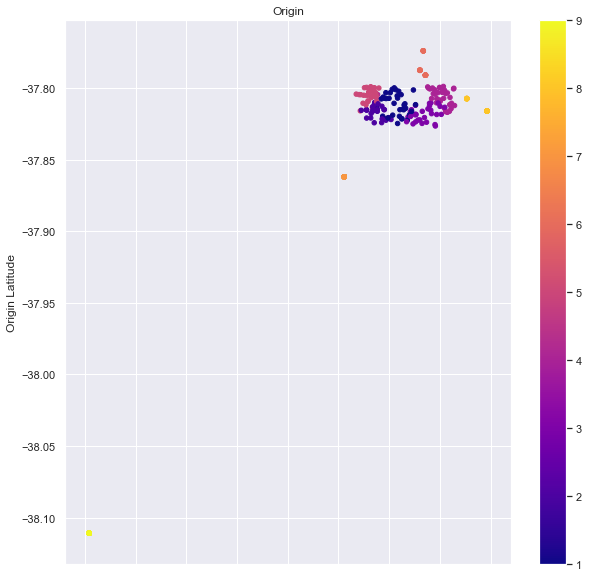

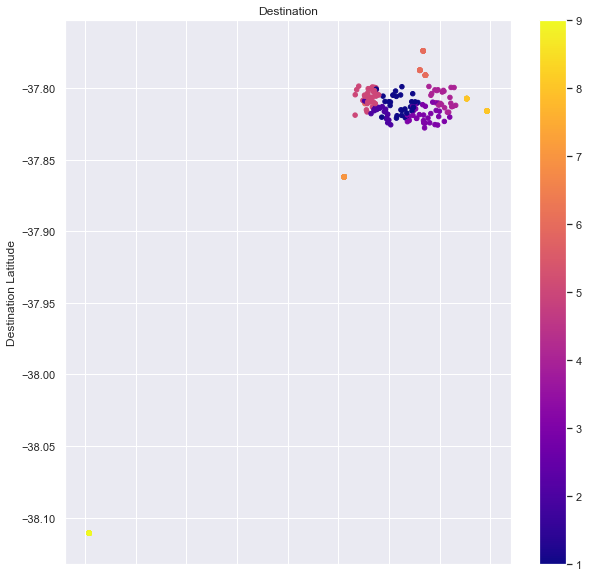

In [19]:
# Origin plot
dd.plot.scatter(x = 'Origin Longitude', y = 'Origin Latitude', figsize=(10,10),
                   c = dd['Origin Region'].values, colormap = 'plasma', title = "Origin")

# Destination plot
dd.plot.scatter(x = 'Destination Longitude', y = 'Destination Latitude', figsize=(10,10),
                   c = dd['Destination Region'].values, colormap = 'plasma', title = "Destination")

Looking at these plots, it seems that the regions are set out in a way that mirrors the natural spread of a city - the inner region is 1, and from there, as the latitude/longitude values spread outwards, so do the regions. So, the regions go from 1 (inner) to 9 (outer).

However, although it is quite hard to see, it looks as though some of the colours are overlapping one another, which would suggest that some of the regions are incorrect.

To fix this, I use the k-nearest neighbour algorithm from sklearn

In [20]:
# Define variables
lat_lon = dd[["Origin Latitude","Origin Longitude"]]
region = dd["Origin Region"]
region.values.reshape(-1,1)

# Initiate classifier
knn_cl = KNeighborsClassifier()
knn_cl.fit(lat_lon, region)

# Predict region
dd['Origin Predicted'] = knn_cl.predict(dd[["Origin Latitude","Origin Longitude"]])
count=0

# Switch incorrect values for predicted value
for i in dd.index:
    if dd["Origin Predicted"][i] != dd['Origin Region'][i]:
        dd['Origin Region'][i] = dd["Origin Predicted"][i]
        count+=1              
print('Number of incorrect origin regions: ', count)

Number of incorrect origin regions:  19


Now, the destination regions with the same method.

In [21]:
# Define variables
lat_lon=dd[["Destination Latitude","Destination Longitude"]]
region=dd["Destination Region"]
region.values.reshape(-1,1)

# Initiate classifier
knn_c1_d = KNeighborsClassifier()
knn_c1_d.fit(lat_lon,region)

# Prediction
dd['Destination Predicted'] = knn_c1_d.predict(dd[["Destination Latitude", "Destination Longitude"]])
count=0

# Switch incorrect values for predicted value
for i in dd.index:
    if dd["Destination Predicted"][i] != dd['Destination Region'][i]:
        dd['Destination Region'][i]=dd["Destination Predicted"][i]
        count+=1              
print('Number of incorrect destination regions: ', count)

Number of incorrect destination regions:  24


Finally, I'll plot the regions again to check that the classifier worked. Once again, although it's hard to see, the regions have become more concretely defined on the plot, so I would say that the KNN classifier was a success.

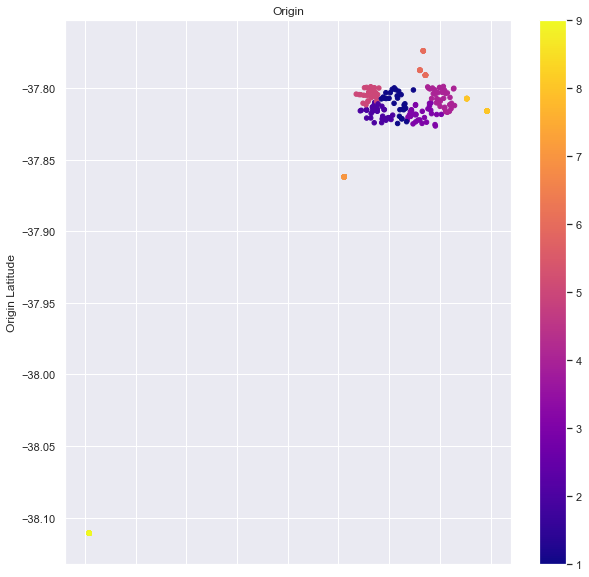

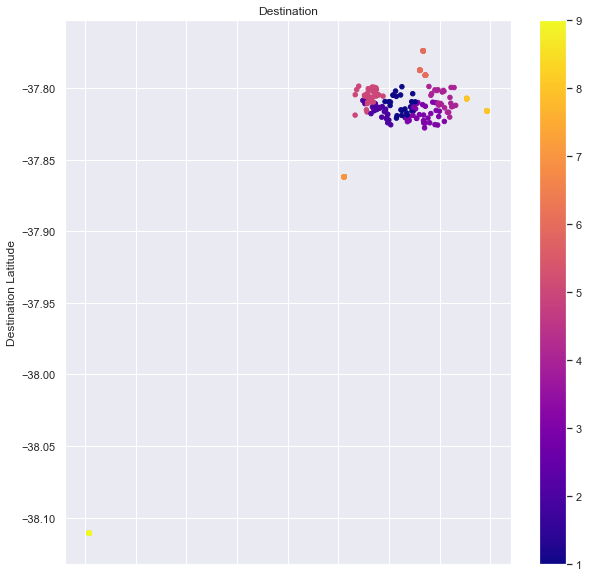

In [22]:
# Origin plot
dd.plot.scatter(x = 'Origin Longitude', y = 'Origin Latitude', figsize=(10,10),
                   c = dd['Origin Region'].values, colormap = 'plasma', title = "Origin")

# Destination plot
dd.plot.scatter(x = 'Destination Longitude', y = 'Destination Latitude', figsize=(10,10),
                   c = dd['Destination Region'].values, colormap = 'plasma', title = "Destination")

Finally, we can clean up the dataframe by removing the temporary columns.

In [23]:
# Drop temporary columns
dd.drop(dd[['Origin Predicted', 'Destination Predicted']], axis=1, inplace = True)

### Journey Distance

First, I read in the edges and nodes file and had a peek at the head.

In [24]:
# Reading in the files
edges = pd.read_csv('edges.csv')
display(edges.head())

nodes = pd.read_csv('nodes.csv')
display(nodes.head())

,Unnamed: 0,u,v,distance(m),street type,speed(km/h)
0,0,711327755,711332946,58.0,1,15.0
1,2,711327755,55725841,15.0,2,20.0
2,3,711327755,711327760,165.0,1,15.0
3,4,711327756,703557073,4.0,0,10.0
4,5,711327756,711332946,8.0,1,15.0


,Unnamed: 0,lat,lon
0,711327755,-37.807675,144.955873
1,711327756,-37.807094,144.955978
2,711327759,-37.807301,144.957817
3,711327760,-37.807885,144.957719
4,777781264,-37.805221,144.952173


In the next cell, I did three things:

- I renamed the nodes columns to match that of the dirty data file, so that merging the two dataframes would be easier.

- I also found that I was having trouble with various longitude/latitude points not being recognised as a match with the node file. I solved this by rounding the amount of decimal places to 10 using .round().

- Finally I did a left outer join on the files to add the origin node to the dirty data dataframe

In [25]:
# Renaming columns to match the data file
nodes.rename(columns={'lat': 'Origin Latitude'}, inplace=True)
nodes.rename(columns={'lon': 'Origin Longitude'}, inplace=True)
nodes.rename(columns={'Unnamed: 0': 'Origin Node'}, inplace=True)

# Rounding to 10 decimal places
nodes['Origin Latitude'] = nodes['Origin Latitude'].round(10)
nodes['Origin Longitude'] = nodes['Origin Longitude'].round(10)

dd['Origin Latitude'] = dd['Origin Latitude'].round(10)
dd['Origin Longitude'] = dd['Origin Longitude'].round(10)

# Left outer join on origin latitude and longitude
dd = pd.merge(dd, nodes, on=['Origin Latitude', 'Origin Longitude'], how = 'left')

I did the same again, but this time with the Desination values, rather than the origin. 

In [26]:
# Renaming columns to match the data file
nodes = pd.read_csv('nodes.csv')
nodes.rename(columns={'lat': 'Destination Latitude'}, inplace=True)
nodes.rename(columns={'lon': 'Destination Longitude'}, inplace=True)
nodes.rename(columns={'Unnamed: 0': 'Destination Node'}, inplace=True)

# Rounding to 10 decimal places
nodes['Destination Latitude'] = nodes['Destination Latitude'].round(10)
nodes['Destination Longitude'] = nodes['Destination Longitude'].round(10)

dd['Destination Latitude'] = dd['Destination Latitude'].round(10)
dd['Destination Longitude'] = dd['Destination Longitude'].round(10)

# Left outer join on destination latitude and longitude
dd = pd.merge(dd, nodes, on=['Destination Latitude', 'Destination Longitude'], how = 'left')

In [27]:
# Peek at the dataframe to check new columns are fine
dd.head()

,ID,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$,Origin Node,Destination Node
0,ID1958251255,0,9,5,-38.110916,144.654172,-37.804697,144.927112,44082.0,2018-02-24,09:41:28,10530.18,12:36:58,22.32,5002706670,581731655
1,ID3328320168,1,7,1,-37.861835,144.905716,-37.820491,144.965925,7426.8,2018-04-18,06:26:22,2636.16,7:10:18,13.15,1390575046,664379579
2,ID1556119881,0,7,3,-37.861835,144.905716,-37.824062,144.984864,8862.0,2018-05-15,04:32:42,2937.12,5:21:39,14.67,1390575046,746924731
3,ID3909610108,1,3,6,-37.824544,144.982460,-37.790797,144.985865,4120.4,2018-03-09,11:32:01,1186.20,11:51:47,7.98,746921889,4307007286
4,ID3874426000,1,6,5,-37.773803,144.983647,-37.805092,144.936967,9684.0,2018-07-04,19:56:24,2957.94,20:45:41,20.48,2455254505,3555805915


Next, I was able to calculate the journey distance using nx.shortest_path_length with the weight set to distance(m) and the method set to dijkstra.


Then, I tested to see if there was any rows that had a different Journey Distance to the calculated value.

In [28]:
# Create the graph
G = nx.from_pandas_edgelist(edges, 'u', 'v', 'distance(m)')

# Function for returning the shortest path
def shortest_path(row):
    return nx.shortest_path_length(G, row['Origin Node'], row['Destination Node'], weight='distance(m)', method = 'dijkstra')

# Apply the function to a new dataframe row
dd['Journey Dist Calc'] = dd.apply(shortest_path, axis=1)

# Find the incorrect values
dd['Compare'] = np.where(dd['Journey Dist Calc'] == dd['Journey Distance(m)'], 'Same', 'Different')
dd.loc[dd['Compare'] == 'Different']

,ID,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$,Origin Node,Destination Node,Journey Dist Calc,Compare
1,ID3328320168,1,7,1,-37.861835,144.905716,-37.820491,144.965925,7426.8,2018-04-18,06:26:22,2636.16,7:10:18,13.15,1390575046,664379579,7427.0,Different
3,ID3909610108,1,3,6,-37.824544,144.982460,-37.790797,144.985865,4120.4,2018-03-09,11:32:01,1186.20,11:51:47,7.98,746921889,4307007286,4111.0,Different
7,ID3572262099,1,3,8,-37.816086,144.982683,-37.815834,145.046450,6247.0,2018-03-01,10:33:12,1831.80,11:03:43,12.10,1449285256,1889485053,6246.0,Different
8,ID3519897376,1,7,6,-37.861835,144.905716,-37.790797,144.985865,11711.3,2018-05-01,03:01:49,3859.80,4:06:08,27.37,1390575046,4307007286,11711.0,Different
10,ID3161008936,1,1,8,-37.814972,144.960615,-37.815834,145.046450,7965.7,2018-06-14,19:17:37,2242.50,19:54:59,17.78,2020813843,1889485053,7968.0,Different
13,ID3282565700,1,6,3,-37.787442,144.980409,-37.819726,144.969655,4256.0,2018-05-01,04:18:29,1127.40,4:37:16,16.92,2204638268,6182893637,4292.0,Different
14,ID3282565700,1,6,3,-37.787442,144.980409,-37.819726,144.969655,4256.0,2018-05-01,04:18:29,1127.40,4:37:16,16.92,2204638268,6182893638,4701.0,Different


This found seven rows that had incorrect Journey Distance values, but I noticed that rows 13 and 14 had the same ID numbers, which can't be right. So upon further inspection, I realised that the same coordinates were given to three separate nodes in the node file. So, I dropped any duplicate values as I am just using the first node value found.

Then, I run through the dataframe and switched the correct values with the incorrect where the 'Compare' column was set to 'Different'. 

Lastly, I dropped the temporary columns to clean up the dataframe.


In [29]:
# Deleting the duplicate row
dd.drop([13,14], inplace = True)

# Reset index 
dd.reset_index(drop = True, inplace = True)

# Switch incorrect values
for i in range(0,len(dd["ID"])):
    if dd["Compare"][i] == 'Different':
        dd["Journey Distance(m)"][i] = dd["Journey Dist Calc"][i]

# Drop temporary columns
dd.drop(dd[['Origin Node', 'Destination Node', 'Journey Dist Calc', 'Compare']], axis=1, inplace=True)

### Departure / Arrival Time

For the departure and arrival times, I checked for any arrival times that are before departure times. I used a for loop to check if the arrival hour was less than that of departure. I know that there's a possibility that trips will go from late at night until early in the morning, so I filter anything out that arrives before 3 am.

It seems as though the two times have been swapped, so I switched them within the loop, and then printed the times just to check everything looks good. 

In [30]:
# Split departure time
dd['Split Departure'] = dd['Departure Time'].str.split(':')
# Split arrival time
dd['Split Arrival'] = dd['Arrival Time'].str.split(':')

# Initialising the loop
for i in range(len(dd['ID'])):
    # Temporary strings
    arrtemp = str()
    depttemp = str()
    
    if int(dd['Split Arrival'][i][0]) > 3:
        if dd['Split Arrival'][i][0] < dd['Split Departure'][i][0]:
            # Adding correct times to the temp strings
            arrtemp = dd['Departure Time'][i]
            depttemp = dd['Arrival Time'][i]
            # Assigning the correct values
            dd['Arrival Time'][i] = arrtemp
            dd['Departure Time'][i] = depttemp
            # Checking
            print(dd['Departure Time'][i], dd['Arrival Time'][i]) 

08:33:05 8:50:44
18:58:36 19:25:05
18:04:54 19:00:38
15:36:21 16:24:23
04:43:52 5:09:16
21:14:35 22:36:32
05:04:35 5:24:06
14:34:27 15:20:23


Finally, we can remove temporary columns.

In [31]:
# Drop unused columns
dd.drop(dd[['Split Departure', 'Split Arrival']], axis=1, inplace = True)

### Travel Time

In [32]:
# Function to determine travel time
def travel_time(path, edges):
    tt = 0
    for i in range(len(path)-1):
        tt = tt + (edges[((edges.u==path[i]) & (edges.v== path[i+1])) | ((edges.v==path[i]) & (edges.u== path[i+1]))]['distance(m)'].values[0] * 1.0 * 3600) / (edges[((edges.u==path[i]) & (edges.v== path[i+1])) | ((edges.v==path[i]) & (edges.u== path[i+1]))]['speed(km/h)'].values[0] * 1000)
    return tt

### Fare

First, I use .describe() to get a feel for the data. Then, as the calculation of the fare is different for each uber type, I created a new .groupby() and .describe() dataframe for fare.

In [33]:
dd['Fare$'].describe()

count     300.000000
mean       70.635833
std       167.701548
min         4.420000
25%        13.760000
50%        18.835000
75%        40.560000
max      1174.950000
Name: Fare$, dtype: float64

In [34]:
# Creating the new dataframe
fare = dd.groupby('Uber Type').describe()

display(fare['Fare$'])

,count,mean,std,min,25%,50%,75%,max
Uber Type,,,,,,,,
0,127.0,14.555433,5.880209,4.42,10.4800,13.84,17.1600,32.55
1,123.0,26.174228,14.341039,6.33,16.8150,20.29,29.0200,62.29
2,50.0,322.455600,305.271519,33.08,112.7275,213.00,329.8975,1174.95


I can't find anything wrong with the values as it seems like none of the values are inconsistent, so I will leave this column as is. 

### Write dataframe to file

Finally, we can save the dataframe to the output file.

In [35]:
# Rename the index and ID column to originals
dd.rename(columns={'ID': ''}, inplace = True)

# Write dataframe to file
dd.to_csv('30042585_dirty_data_solution.csv', index = False)

## 4. Outlier Data

For this task, I first read in the outlier file and renamed the ID column.

Interestingly, there is an extra column in this dataframe that looks like an index. We will leave it as the assignment states there shuld be exactly the same amount of columns in the output as there were in the input.

In [36]:
# Read in the file
od = pd.read_csv('30042585_outliers.csv')

# Rename the ID column
od.rename(columns={'Unnamed: 0.1': 'ID'}, inplace=True)

#Peek at the head of the data
od.head()

,Unnamed: 0,ID,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$
0,0,ID3854020684,1,2,4,-37.815928,144.938157,-37.807126,144.991564,5141.0,2018-05-15,12:17:59,1302.36,12:39:41,14.02
1,1,ID3455540502,1,8,1,-37.807202,145.026637,-37.819696,144.946897,8306.0,2018-05-03,17:14:25,1956.84,17:47:01,18.12
2,2,ID3463099350,1,7,4,-37.861835,144.905716,-37.801159,145.014580,13105.0,2018-03-27,20:39:56,4180.38,21:49:36,13.68
3,3,ID1271303505,0,8,4,-37.815834,145.046450,-37.816218,145.007396,3940.0,2018-05-11,17:17:38,1291.98,17:39:09,8.13
4,4,ID3789763899,1,7,4,-37.861835,144.905716,-37.811918,145.009667,11859.0,2018-07-01,16:59:44,3818.46,18:03:22,28.69


To begin with, I start by using shape and .describe() to get a feel for the data.

In [37]:
# Print the shape and description
print('Shape of the outlier dataframe: ', od.shape)
display(od.describe())

Shape of the outlier dataframe:  (112, 15)


,Unnamed: 0,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Travel Time(s),Fare$
count,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000
mean,55.500000,0.651786,5.401786,4.473214,-37.861454,144.918558,-37.839699,144.939441,15952.955357,4190.911607,54.212500
std,32.475632,0.693728,2.587077,2.571359,0.104337,0.116020,0.082835,0.093165,17075.414027,4123.449873,138.696125
min,0.000000,0.000000,1.000000,1.000000,-38.110916,144.654173,-38.110916,144.654173,1238.000000,298.980000,2.220000
25%,27.750000,0.000000,3.000000,2.000000,-37.861835,144.905716,-37.820759,144.932148,4528.500000,1290.195000,9.918750
50%,55.500000,1.000000,5.500000,4.000000,-37.815834,144.943503,-37.814968,144.947498,8815.000000,2703.750000,16.660000
75%,83.250000,1.000000,8.000000,7.000000,-37.810426,144.985865,-37.807183,144.988056,12592.750000,3995.880000,28.950000
max,111.000000,2.000000,9.000000,9.000000,-37.773845,145.046450,-37.773803,145.046450,51061.000000,13204.980000,1104.730000


We can see that the categorical data (Uber Type, Origin Region and Destination Region) look fine as they all the values are within the required ranges. The latitude and longitude values also look acceptable, as they are all within their scope and the standard deviation is low. This leaves Journey Distance, Travel Time, and Fare$ - which will be explored separately in the following sections. 
 
### Find Outliers
#### Journey Distance

First, I used graphical exploratory data analysis. I set up a function to find the median difference, and then plot the data onto a graph using this function.

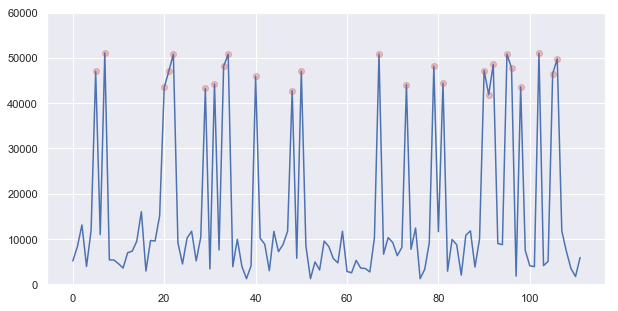

In [38]:
# Setting up a function
def get_median_filtered(signal, threshold=3):
    signal = signal.copy()
    # Find the median difference
    difference = np.abs(signal - np.median(signal))
    median_difference = np.median(difference)
    if median_difference == 0:
        s = 0
    else:
        s = difference / float(median_difference)
    mask = s > threshold
    signal[mask] = np.median(signal)
    return signal

# Defining plot style
figsize = (10, 5)
kw = dict(marker = 'o', linestyle = 'none', color = 'r', alpha = 0.3)

# Finding data points using function
od['jd_med'] = get_median_filtered(od['Journey Distance(m)'].values, threshold = 3)
outlier_idx = np.where(od['jd_med'].values != od['Journey Distance(m)'].values)[0]

# Plotting
fig, ax = plt.subplots(figsize=figsize)
od['Journey Distance(m)'].plot()
od['Journey Distance(m)'][outlier_idx].plot(**kw)
_ = ax.set_ylim(0, 60000)

I also decided to to make a boxplot using seaborn.

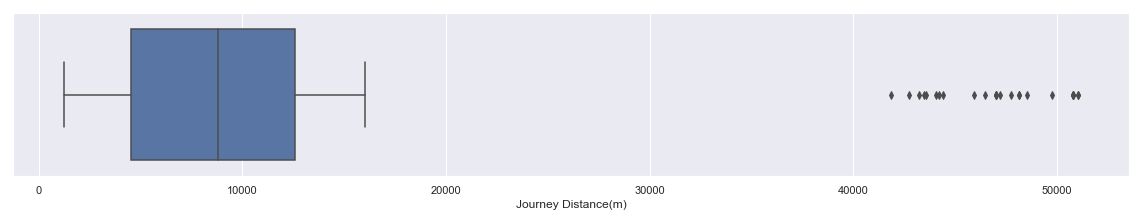

In [41]:
sns.boxplot(x = od['Journey Distance(m)'])

We can see from these plots that there are significant outliers from about 40,000 metres onwards.

Next, I used a non-graphical method to find the outliers.

In [42]:
# Finding the 25th and 75th percentiles
Q1 = od['Journey Distance(m)'].quantile(0.25)
Q3 = od['Journey Distance(m)'].quantile(0.75)

# Finding the interquartile range
IQR = Q3 - Q1

# Finding the lower and upper fences
lower_fence = Q1 -(1.5 * IQR) 
print('Lower fence: ', lower_fence)
upper_fence = Q3 +(1.5 * IQR) 
print('Upper fence: ', upper_fence)

Lower fence:  -7567.875
Upper fence:  24689.125


The lower fence is -7567.875 and the upper fence is 24689.125, so anything outside of these values is an outlier.

So now I filter out all the values above the upper fence, and add the index values to a list for removal after the outliers for every variable are detected.

In [43]:
# Filter out values about upper fence
jd_outliers = od.loc[od['Journey Distance(m)'] > 24689.125]
print('Number of Journey Distance outliers: ', len(jd_outliers))

# Add to list for removal at the end
jd_outliers = jd_outliers.index.tolist()

Number of Journey Distance outliers:  25


#### Travel Time

Next is Travel Time, which follows the same process as the Journey Distance.

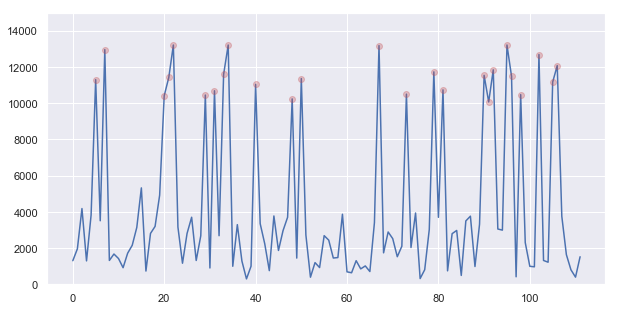

In [44]:
# Creating the plot
figsize = (10, 5)
kw = dict(marker='o', linestyle='none', color='r', alpha = 0.3)

od['tt_med'] = get_median_filtered(od['Travel Time(s)'].values, threshold = 3)
outlier_idx = np.where(od['tt_med'].values != od['Travel Time(s)'].values)[0]

fig, ax = plt.subplots(figsize=figsize)
od['Travel Time(s)'].plot()
od['Travel Time(s)'][outlier_idx].plot(**kw)
_ = ax.set_ylim(0, 15000)

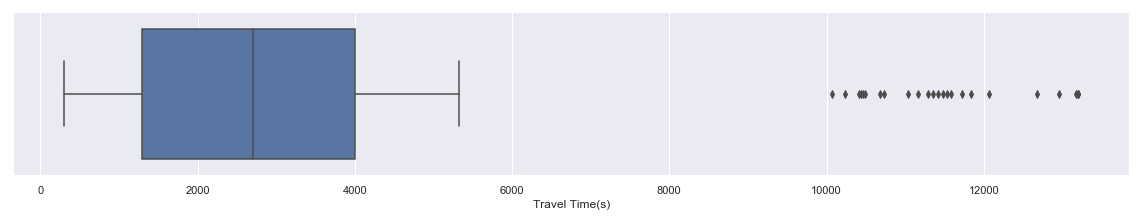

In [45]:
# Creating the boxplot
sns.boxplot(x = od['Travel Time(s)'])

Again, there are some clearly observable outliers in the data, at about the 10,000 mark and onwards.

Finding the IQR and lower/upper fences.

In [46]:
# IQR
Q1 = od['Travel Time(s)'].quantile(0.25)
Q3 = od['Travel Time(s)'].quantile(0.75)
IQR = Q3 - Q1

# Lower/upper fences
lower_fence = Q1 -(1.5 * IQR) 
print('Lower fence: ', lower_fence)
upper_fence = Q3 +(1.5 * IQR) 
print('Upper fence: ', upper_fence)

Lower fence:  -2768.3324999999973
Upper fence:  8054.407499999996


Finally, the outliers index list is made. This list has 25 entries.

In [47]:
# Filtering out outliers
tt_outliers = od.loc[od['Travel Time(s)'] > 8054.407]
print('Number of Travel Time outliers: ',len(tt_outliers))

# Add to removal list
tt_outliers = tt_outliers.index.tolist()

Number of Travel Time outliers:  25


#### Fare

Lastly, the Fare column.

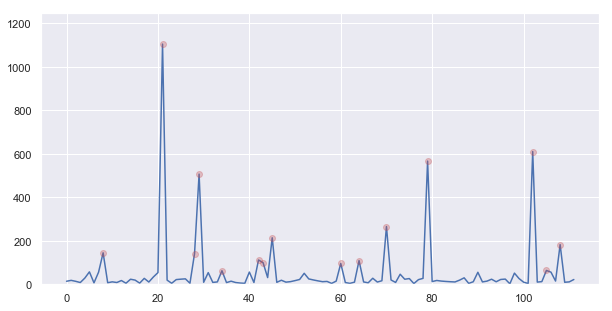

In [48]:
# Create the plot
figsize = (10, 5)
kw = dict(marker='o', linestyle='none', color='r', alpha = 0.3)

od['fare_med'] = get_median_filtered(od['Fare$'].values, threshold = 5)

outlier_idx = np.where(od['fare_med'].values != od['Fare$'].values)[0]

fig, ax = plt.subplots(figsize=figsize)
od['Fare$'].plot()
od['Fare$'][outlier_idx].plot(**kw)
_ = ax.set_ylim(0, 1250)

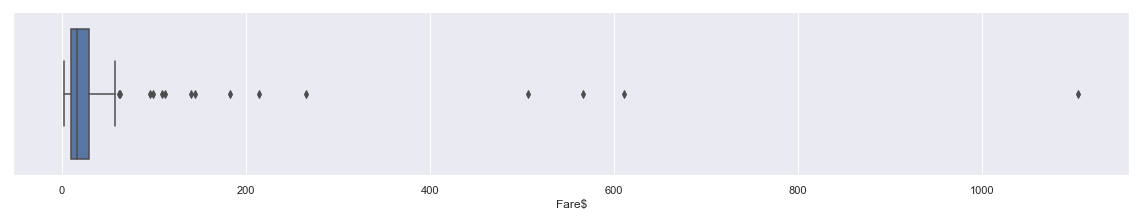

In [49]:
# Create the boxplot
sns.boxplot(x = od['Fare$'])

Once again, we can clearly see there are outliers here, so we again find the IQR and lower/upper fences.

In [50]:
# IQR
Q1 = od['Fare$'].quantile(0.25)
Q3 = od['Fare$'].quantile(0.75)
IQR = Q3 - Q1

# Lower/upper fences
lower_fence = Q1 -(1.5 * IQR) 
print('Lower fence: ', lower_fence)
upper_fence = Q3 +(1.5 * IQR) 
print('Upper fence: ', upper_fence)

Lower fence:  -18.628124999999997
Upper fence:  57.496875


Lastly, filter the outliers and add to a removal list.

In [51]:
fare_outliers = od.loc[od['Fare$'] > 57.497]
print(len(fare_outliers))

# add to list for removal at the end
fare_outliers = fare_outliers.index.tolist()

15


### Remove Outliers + Save File

Finally, the outliers need to be removed from the dataset. To do this, I added all the removal index lists together, and converted it into a set to remove any duplicate values. 

In [52]:
# Add the lists together 
removal_list = jd_outliers + tt_outliers + fare_outliers
# Print the length out of curiosity
print('Outlier list: ', len(removal_list))

# Transform into a set 
removal_list = set(removal_list)
print('Outlier set: ',len(removal_list))
print('Removal list: ', removal_list)

Outlier list:  65
Outlier set:  34
Removal list:  {5, 7, 8, 20, 21, 22, 28, 29, 31, 33, 34, 40, 42, 43, 45, 48, 50, 60, 64, 67, 70, 73, 79, 81, 90, 91, 92, 95, 96, 98, 102, 105, 106, 108}


Next, I dropped the outlier rows and the temporary columns. I also printed the shape just to check everything was in order.

In [53]:
# Drop the outlier rows
od.drop(od.index[[5, 7, 8, 20, 21, 22, 28, 29, 31, 33, 34, 40, 42, 43, 45, 48, 50, 60, 64, 67, 70, 73, 79, 81, 90, 91, 92, 95, 96, 98, 102, 105, 106, 108]], inplace = True)
# Drop temporary columns
od.drop(['jd_med', 'tt_med', 'fare_med'], axis = 1, inplace = True)

# Print the shape
print('Shape of the outlier dataframe: ', od.shape)

Shape of the outlier dataframe:  (78, 15)


I decided to have a final peek at the boxplots just to ensure validity of the removal technique, which I was happy with.

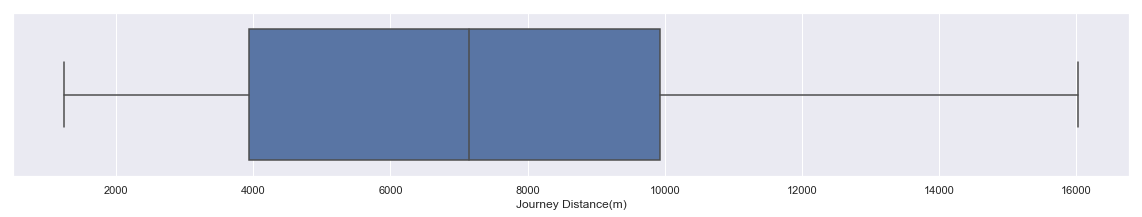

In [54]:
sns.boxplot(x = od['Journey Distance(m)'])

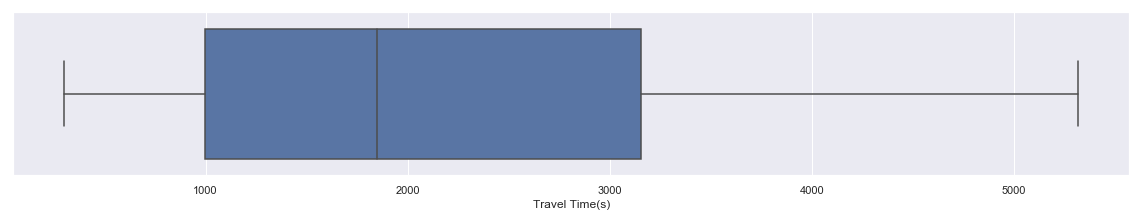

In [55]:
sns.boxplot(x = od['Travel Time(s)'])

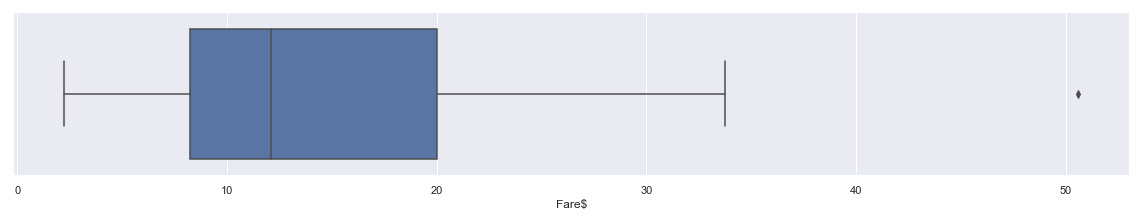

In [56]:
sns.boxplot(x = od['Fare$'])

Finally, we can write the output data to a csv file using Pandas to_csv.

In [57]:
# Rename the index and ID column to originals
od.rename(columns={'Unnamed: 0': ''}, inplace=True)
od.rename(columns={'ID': 'Unnamed: 0'}, inplace=True)

# Writing to output file
od.to_csv('30042585_outliers_solution.csv', index = False)

## 4. Missing Value Data

For the final task and dataset, I once again read in the dataset and rename the ID column.

In [58]:
# Read in the dataset and rename ID column
md = pd.read_csv('30042585_missing_value.csv')
md.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)

# Peek at the data
print(md.shape)
md.head()

(121, 14)


,ID,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$
0,ID5559165491,2.0,8,6,-37.807202,145.026637,-37.773803,144.983647,11470.0,2018-05-07,07:46:36,3458.94,8:44:14,280.54
1,ID1391942606,NaN,7,4,-37.861835,144.905716,-37.801562,144.996775,11539.0,2018-06-17,07:56:38,3753.00,8:59:11,13.51
2,ID1804057934,0.0,5,9,-37.802796,144.936429,-38.110916,144.654173,43817.0,2018-07-27,00:37:30,10508.46,3:32:38,31.65
3,ID1736641249,0.0,8,4,-37.815834,145.046450,-37.803248,145.001800,5115.0,2018-07-24,14:20:26,1567.68,14:46:33,11.62
4,ID3403476115,1.0,9,4,-38.110916,144.654173,-37.801151,144.988756,46519.0,2018-05-15,19:19:22,11229.66,22:26:31,48.73


To find the null values, I used .isnull().sum(). From this, we can see that both Uber Type and Fare have missing values.

Let's work on Uber Type first.

In [59]:
md.isnull().sum()

ID                        0
Uber Type                19
Origin Region             0
Destination Region        0
Origin Latitude           0
Origin Longitude          0
Destination Latitude      0
Destination Longitude     0
Journey Distance(m)       0
Departure Date            0
Departure Time            0
Travel Time(s)            0
Arrival Time              0
Fare$                    17
dtype: int64

### Fixing Missing Uber Type

There are 19 missing uber type values.

We already know from the Dirty Data dataset that the Uber Types are linked to the ID, so we can call on the same function to fill in the missing values.


In [60]:
md['Uber Type'].value_counts()

1.0    44
0.0    42
2.0    16
Name: Uber Type, dtype: int64

In [61]:
# Define the function
def replace_uber_type(row):
    # Convert the ID to a string and strip
    strid=str(row['ID'])
    strid=strid.replace('ID','') 
    # Check if the id starts with 1 
    if(strid.startswith('1')): 
        #sub in uber type
        row['Uber Type'] = 0 
    elif(strid.startswith('3')):
        row['Uber Type'] = 1
    else:
        row['Uber Type'] = 2      
    return row

# Apply the function to the rows
md = md.apply(lambda row: replace_uber_type(row), axis=1)

Lastly, I check the value counts - everything looks good, and each Uber Type has incread in value count. 

In [62]:
md['Uber Type'].value_counts()

1    55
0    48
2    18
Name: Uber Type, dtype: int64

### Fixing Missing Fare Values

There are 17 missing 'Fare' values.

Initially, I tried finding correlations using the entire dataset. After finding little success with this attempt, I realised that the fare is calculated in different ways based on Uber Type. 

So, before I could do the linear regression on each Uber Type, I did a bit of pre-processing:

- Firstly, I converted the Departure Date and Time to ordinal or numeric values in a new column as linear regression doesn't work on date data.

- Then, I worked out the day of the week using dt.dayofweek in case the fare changes on weekdays vs weekends and created a new column. I had to go back and change the values after a forum post was made saying that weekdays should have a value of 0 and weekends should have a value of 1. This was simple enough, though, with a quick for loop.

- From here, I split the dataset into sections according to Uber type to create three new dataframes.


In [63]:
# Converting to ordinal values
md['Ordinal Datetime'] = pd.to_datetime(md['Departure Date'] + ' ' + md['Departure Time']).map(dt.datetime.toordinal)

# Finding day of week
md['Departure Date'] = pd.to_datetime(md['Departure Date'], format='%Y-%m-%d')
md['Weekday'] = md['Departure Date'].dt.dayofweek

# Retroactively convert days to 0 for weekdays and 1 for weekends as per forum post.
weekday = [0,1,2,3,4]

for i in range(len(md['Weekday'])):
    if md['Weekday'][i] in weekday:
        md['Weekday'][i] = 0
    else:
        md['Weekday'][i] = 1

# Create new dataframes
uber_0 = md.loc[md['Uber Type'] == 0]
uber_1 = md.loc[md['Uber Type'] == 1]
uber_2 = md.loc[md['Uber Type'] == 2]

#### Linear Regression - Uber Type 0

Now for the linear regression on uber Type 0. First, we use .corr() to find the correlations between each variable and the fare for Uber type 0


In [64]:
# Find correlations
correlations_0 = uber_0[['Origin Region', 'Destination Region',  'Journey Distance(m)', 'Travel Time(s)',
                         'Arrival Time', 'Ordinal Datetime', 'Weekday', 'Fare$']].corr()
# Display
display(correlations_0)

,Origin Region,Destination Region,Journey Distance(m),Travel Time(s),Ordinal Datetime,Weekday,Fare$
Origin Region,1.000000,-0.019414,0.431531,0.457341,0.308930,-0.291233,0.187420
Destination Region,-0.019414,1.000000,0.608083,0.614671,0.020067,0.200628,0.611146
Journey Distance(m),0.431531,0.608083,1.000000,0.996621,0.075469,0.028246,0.895805
Travel Time(s),0.457341,0.614671,0.996621,1.000000,0.062929,0.023555,0.886150
Ordinal Datetime,0.308930,0.020067,0.075469,0.062929,1.000000,0.050351,-0.097249
Weekday,-0.291233,0.200628,0.028246,0.023555,0.050351,1.000000,0.264920
Fare$,0.187420,0.611146,0.895805,0.886150,-0.097249,0.264920,1.000000


From the above table, we can see that the Fare value shares a strong positive correlation with 'Destination Region', 'Journey Distance', and 'Travel Time(s)'. It also shares a postive correlation with 'Origin Region' and 'Weekday', but it is  weak.

However, I will still add these values as, through trial and error, I found that the R-squared value is higher when these variables.


In [65]:
# Creating new dataframe with relevant columns
fare_0 = pd.DataFrame(uber_0[['Origin Region', 'Destination Region', 'Journey Distance(m)', 'Travel Time(s)', 'Weekday', 'Fare$']], 
                      columns=['Origin Region', 'Destination Region','Journey Distance(m)', 'Travel Time(s)', 'Weekday', 'Fare$'])

# Checking the null values
fare_0.isnull().sum()

Origin Region          0
Destination Region     0
Journey Distance(m)    0
Travel Time(s)         0
Weekday                0
Fare$                  6
dtype: int64

Next, we create the training model using train_test_split from sklearn. I created a new dataframe which is a copy of fare_0 but with dropped the NaN values. I then split this into test and train sets with 20% of the data going to the test data and the rest remaining in the training set. I then fit the data with LinearRegression().

In [66]:
# Drop NaN values
nonan_0 = fare_0.dropna()

# Split the into test and train sets
train, test = train_test_split(nonan_0, test_size=0.2)

# Fit the data
linear_reg_0 = LinearRegression().fit(nonan_0[['Origin Region', 'Destination Region','Journey Distance(m)', 'Travel Time(s)', 'Weekday']], nonan_0['Fare$']) 

Next, I check the accuracy of the model using R square and mean squared error (MSE). 

In [67]:
# Predict the fare
nonan_0['Predict Fare'] = linear_reg_0.predict(nonan_0[['Origin Region', 'Destination Region', 'Journey Distance(m)', 'Travel Time(s)', 'Weekday']])

# Check for R squared and MSE values
y_true = nonan_0['Fare$']
y_pred = nonan_0['Predict Fare']

print('R square :' + str(r2_score(y_true, y_pred)))
print('MSE :' + str(mean_squared_error(y_true, y_pred)))

R square :0.8629107364947152
MSE :9.778698626608573


I'm happy with the accuracy of the model, so now I'll apply it to the dataset.


In [68]:
# Function for replacing the NaN fare values
def replace_null_fare_0(row):
    # Predict
    predicted_fare = linear_reg_0.predict([[row['Origin Region'], row['Destination Region'],row['Journey Distance(m)'], row['Travel Time(s)'], row['Weekday']]])
    # Round the value
    predicted_fare = round(predicted_fare[0],2)
    # Apply to row
    row['Fare$'] = predicted_fare
    return row

# Applying the function
uber_0[uber_0['Fare$'].isnull() == True] = uber_0[uber_0['Fare$'].isnull() == True].apply(lambda row: replace_null_fare_0(row), axis=1)    


#### Linear Regression - Uber Type 1

Now we can enact the same process for Uber type 1.



In [69]:
# Finding correlations
correlations_1 = uber_1[['Origin Region', 'Destination Region',  'Journey Distance(m)', 'Departure Date', 
                         'Departure Time', 'Arrival Time', 'Travel Time(s)', 'Ordinal Datetime', 'Weekday', 'Fare$']].corr()

display(correlations_1)

,Origin Region,Destination Region,Journey Distance(m),Travel Time(s),Ordinal Datetime,Weekday,Fare$
Origin Region,1.000000,-0.014853,0.385294,0.429134,0.151248,-0.030918,0.359976
Destination Region,-0.014853,1.000000,0.555092,0.571494,0.134074,0.164123,0.565091
Journey Distance(m),0.385294,0.555092,1.000000,0.993787,0.196841,0.238660,0.943930
Travel Time(s),0.429134,0.571494,0.993787,1.000000,0.203951,0.232314,0.954765
Ordinal Datetime,0.151248,0.134074,0.196841,0.203951,1.000000,0.036746,0.249515
Weekday,-0.030918,0.164123,0.238660,0.232314,0.036746,1.000000,0.313206
Fare$,0.359976,0.565091,0.943930,0.954765,0.249515,0.313206,1.000000


In [70]:
# Creating new datframe with relevant columns

fare_1 = pd.DataFrame(uber_1[['Origin Region', 'Destination Region', 'Journey Distance(m)', 'Travel Time(s)', 'Ordinal Datetime', 'Weekday', 'Fare$']], 
                      columns=[ 'Origin Region', 'Destination Region','Journey Distance(m)', 'Travel Time(s)', 'Ordinal Datetime', 'Weekday', 'Fare$'])

# Finding sum of NaN values
fare_1.isnull().sum()

Origin Region          0
Destination Region     0
Journey Distance(m)    0
Travel Time(s)         0
Ordinal Datetime       0
Weekday                0
Fare$                  7
dtype: int64

In [71]:
# Drop NaN values
nonan_1 = fare_1.dropna()

# Split into test and train set
train, test = train_test_split(nonan_1, test_size=0.2)

# Fit the data
linear_reg_1 = LinearRegression().fit(nonan_1[['Origin Region', 'Destination Region', 'Journey Distance(m)', 
                                  'Travel Time(s)','Ordinal Datetime', 'Weekday']], nonan_1['Fare$']) 

In [72]:
# Predict 
nonan_1['predDelFare2'] = linear_reg_1.predict(nonan_1[['Origin Region', 'Destination Region',
                                         'Journey Distance(m)', 'Travel Time(s)','Ordinal Datetime', 'Weekday']])
# Check R squared and MSE
y_true = nonan_1['Fare$']
y_pred = nonan_1['predDelFare2']
print('R square :'+str(r2_score(y_true, y_pred)))
print('MSE :'+str(mean_squared_error(y_true, y_pred)))

R square :0.9354993629274956
MSE :12.322105660851358


In [73]:
# Replace NaN values
def replace_null_fare_1(row):
    predicted_fare_1 = linear_reg_1.predict([[row['Origin Region'], row['Destination Region'], 
                                              row['Journey Distance(m)'], row['Travel Time(s)'], 
                                              row['Ordinal Datetime'], row['Weekday']]])
    predicted_fare_1 = round(predicted_fare_1[0],2)
    row['Fare$'] = predicted_fare_1
    return row

uber_1[uber_1['Fare$'].isnull() == True] = uber_1[uber_1['Fare$'].isnull() == True].apply(lambda row: replace_null_fare_1(row), axis=1)    

#### Linear Regresion - Uber Type 2


In [74]:
# Finding correlations
correlations_2 = uber_2[['Origin Region', 'Destination Region',  'Journey Distance(m)', 'Departure Date', 
                         'Departure Time', 'Arrival Time', 'Travel Time(s)', 'Ordinal Datetime', 'Weekday', 'Fare$']].corr()

display(correlations_2)

,Origin Region,Destination Region,Journey Distance(m),Travel Time(s),Ordinal Datetime,Weekday,Fare$
Origin Region,1.000000,-0.492284,0.236273,0.272836,0.273124,-0.213012,0.169627
Destination Region,-0.492284,1.000000,0.240551,0.238723,0.389866,-0.037275,0.365326
Journey Distance(m),0.236273,0.240551,1.000000,0.995613,0.349393,-0.195288,0.995347
Travel Time(s),0.272836,0.238723,0.995613,1.000000,0.383396,-0.206508,0.999651
Ordinal Datetime,0.273124,0.389866,0.349393,0.383396,1.000000,0.015104,0.272150
Weekday,-0.213012,-0.037275,-0.195288,-0.206508,0.015104,1.000000,-0.190079
Fare$,0.169627,0.365326,0.995347,0.999651,0.272150,-0.190079,1.000000


In [75]:
# Creating new datframe
fare_2 = pd.DataFrame(uber_2[['Origin Region', 'Destination Region','Journey Distance(m)', 'Travel Time(s)','Ordinal Datetime', 'Fare$']], 
                      columns=['Origin Region', 'Destination Region','Journey Distance(m)', 'Travel Time(s)','Ordinal Datetime', 'Fare$'])
# Checking NaN values
fare_2.isnull().sum()

Origin Region          0
Destination Region     0
Journey Distance(m)    0
Travel Time(s)         0
Ordinal Datetime       0
Fare$                  4
dtype: int64

In [76]:
# Drop NaN values
fare_nonan_2 = fare_2.dropna()

# Split into test and train set
train, test = train_test_split(fare_nonan_2 , test_size=0.2)

# Fit the data
linear_reg_2 = LinearRegression().fit(fare_nonan_2 [['Origin Region', 'Destination Region','Journey Distance(m)',
                                  'Travel Time(s)', 'Ordinal Datetime']], fare_nonan_2 ['Fare$']) 

In [77]:
# Predict
fare_nonan_2['predDelFare2'] = linear_reg_2.predict(fare_nonan_2 [['Origin Region', 'Destination Region','Journey Distance(m)', 
                                                                   'Travel Time(s)', 'Ordinal Datetime']])
# Check R squared and MSE
y_true = fare_nonan_2 ['Fare$']
y_pred = fare_nonan_2 ['predDelFare2']

print('R square :' + str(r2_score(y_true, y_pred)))
print('MSE :' + str(mean_squared_error(y_true, y_pred)))

R square :0.9998636403422193
MSE :10.752632498653059


In [78]:
# Replace NaN values
def replace_null_fare_2(row):
    predicted_fare_2 = linear_reg_2.predict([[ row['Origin Region'], row['Destination Region'], row['Journey Distance(m)'], row['Travel Time(s)'], row['Ordinal Datetime']]])
    predicted_fare_2 = round(predicted_fare_2[0],2)
    row['Fare$'] = predicted_fare_2
    return row

uber_2[uber_2['Fare$'].isnull()==True]=uber_2[uber_2['Fare$'].isnull()==True].apply(lambda row: replace_null_fare_2(row), axis=1)    

### Put Dataframe Back Together and Save


Finally, all that is left is to clean up the dataframe and save it to a file



In [79]:
# Append the dataframes together
result_1 = uber_0.append(uber_1)
result = result_1.append(uber_2)

# Drop temporary columns
result.drop(['Ordinal Datetime', 'Weekday'], axis = 1, inplace = True)

# Sort on the axis 
result.sort_index(axis=0, inplace = True)

# Rename ID column back to original
result.rename(columns={'ID': ''}, inplace=True)

# Check shape is the same
print(result.shape)

# Save to file
result.to_csv('30042585.missing_value_solution.csv', index = False)

(121, 14)


## 6. Summary

This assignment involved the wrangling of datafiles with Uber ridesharing data. I used various detection, cleaning, and imputing methods to complete it. The main tasks are summarised as follows:


- **Dirty Data Wrangling**. This was a long process with a lot of trial and error involved. Having to check every single column was arduous, and left room for error. However, I did my best and I think that I located and fixed most of the erros in the dataset. 


- **Outlier Data Wrangling**. This was a relatively straightforward task. By using the outlier detection approach that I used, I was able to quickly find the outliers and use the same process for each outlier variable, which made the task quick to finish. I found that most of the outliers were from Uber Type 2, which made me think that maybe it would have been good to have the dataset split into three different datasets, one for each Uber Type. However, that's not what the assignment asked for!


- **Missing Data Wrangling**. This was a relatively uncomplicated task as there are a lot of great packages within python that allow users to do linear regression really easily. In addition, although it's not perfect, using linear regression is a great way to impute missing values. 



## 7. References


- Hagberg A, Schult D, Swart P. (2019 April 11). *NetworkX Reference Release 2.3*. Retrieved from https://networkx.github.io/documentation/stable/_downloads/networkx_reference.pdf

- Chauhan, N. (2019 February 25). *A beginner’s guide to Linear Regression in Python with Scikit-Learn*. Retrieved from https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f

- Scikit-learn. (2019). *sklearn.neighbors.KNeighborsClassifier*. Retrieved from https://scikitlearn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

- The pandas Project. (2016). *pandas 0.19.2 documentation: pandas.DataFrame.groupby*. Retrieved from https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html#pandas-dataframe-groupby
